In [1]:
from constants import DatasetPath

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tqdm.notebook import tqdm
import os

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [6]:
# Main Dataset folder path
DATA_DIR = DatasetPath.effectivePath

# HYPERPARAMETRES

BATCH_SIZE = 16

LR = 0.001

EPOCHS = 10

# Device to run calculations on 
DEVICE = 'cuda'

In [7]:
df = pd.read_csv(DATA_DIR + "filtered_input.csv")

train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)
print(len(train_df))
print(len(valid_df))
print(df.shape)

19912
4979
(24891, 3)


In [8]:
# Class to provide useful functions and prepare the data for NN use 
class APN_Dataset(Dataset):
    """
    Uploads images from Dataset and set them up for Neural Network use.

    Parameters
    ----------
        Dataset (pd.DataFrame): the DataFrame containing the dataset.
    """
    
    def __init__(self, df):
        """
        Initializes the class with the DataFrame in input.

        Parameters
        ----------
            df (pd.DataFrame): the DataFrame containing the dataset.
        """
        self.df = df

    def __len__(self):
        """
        Calculates the number of tuples in the dataset.

        Returns
        -------
            (int): number of tuples in the dataset.
        """    
        return len(self.df)

    def __getitem__(self, idx):
        """
        Retrieves the images at the given row index.

        Parameters
        ----------
            idx (int): dataset row index.

        Returns
        -------
            A_img, P_img, N_img (ndarray): the anchor, positive and negative images at row[idx] 
        """
        row = self.df.iloc[idx]

        A_img = io.imread(DATA_DIR + row.anchor)
        P_img = io.imread(DATA_DIR + row.positive)
        N_img = io.imread(DATA_DIR + row.negative)

        #Permute because the third channel has to be in first channel in torch

        #A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
        #P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
        #N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0


        A_img = np.expand_dims(A_img, 0)
        P_img = np.expand_dims(P_img, 0)
        N_img = np.expand_dims(N_img, 0)

        A_img = torch.from_numpy(A_img) / 255.0
        P_img = torch.from_numpy(P_img) / 255.0
        N_img = torch.from_numpy(N_img) / 255.0

        #A_img = torch.from_numpy(A_img.astype(np.int32)) / 65536.0
        #P_img = torch.from_numpy(P_img.astype(np.int32)) / 65536.0
        #N_img = torch.from_numpy(N_img.astype(np.int32)) / 65536.0

        return A_img, P_img, N_img

In [9]:
# APN_Dataset objects creation

trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset: {len(trainset)}")
print(f"Size of validset: {len(validset)}")

Size of trainset: 19912
Size of validset: 4979


In [10]:
# DataLoader creation to handle loading data into memory

trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 1245
No. of batches in validloader : 312


In [11]:
class APN_Model(nn.Module):
    """
    Defines a neural network model class APN_Model that uses an EfficientNet (specifically the B0 version) as its backbone.
    """

    def __init__(self, emb_size = 512):
        """
        Initializes the APN_Model with a specific model and a classifier that outputs embedding vector of the specified size.

        Parameters
        ----------
        emb_size (int, optional): the size of the output embedding vector (default is 512).
        """
        super(APN_Model, self).__init__()

        # Define the model to use 
        self.efficientnet = timm.create_model('tf_efficientnetv2_b0', pretrained = False)
        
        # Replace the classifier layer with a linear layer that outputs embeddings of size `emb_size`
        self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

    def forward(self, images):
        """
        Performs the forward pass of the model, which takes a batch of images and returns their embeddings.

        Parameters
        ----------
            images (torch.Tensor): a batch of images to process.

        Returns
        -------
            embeddings (torch.Tensor): a batch of embeddings of size `emb_size`.
        """
        embeddings = self.efficientnet(images)
        return embeddings

In [ ]:
# NN mod to accept greyscale fourier spectrum images instead of RGB

model = APN_Model()
model.efficientnet.conv_stem = nn.Conv2d(1, 32, 3, 2, 1, bias=False)

model.to(DEVICE)

In [13]:
def train_fn(model, dataloader, optimizer, criterion):
    """
    Trains the model for one epoch using the provided dataloader, optimizer, and criterion.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model to be trained.
        dataloader (torch.utils.data.DataLoader): the dataloader providing batches of anchor, positive, and negative image triplets.
        optimizer (torch.optim.Optimizer): the optimizer used to update the model's parameters.
        criterion (function): the loss function used to compute the loss between the model's outputs.

    Returns
    -------
        (float) : the average training loss over all batches.
    """

    # Sets the model to training mode
    model.train() #ON Dropout
    total_loss = 0.0

    # Iterates over the batches of data provided by the dataloader.
    # Each batch consists of triplets: anchor (A), positive (P), and negative (N) images.
    for A, P, N in tqdm(dataloader):
        # Moves the anchor, positive, and negative images to the specified device.
        A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

        # Passes the anchor, positive, and negative images through the model to obtain their embeddings.
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)

        # Computes the loss using the specified loss function
        loss = criterion(A_embs, P_embs, N_embs)

        # Clears the gradients of all optimized parameters.
        # Important to prevent accumulation of gradients from multiple forward passes.
        optimizer.zero_grad()

        # Computes the gradient of the loss with respect to the model's parameters (backpropagation).
        loss.backward()
        
        # Updates the model's parameters based on the computed gradients.
        optimizer.step()

        # Updates toal loss at the end of each iteration
        total_loss += loss.item()

    return total_loss / len(dataloader)

In [14]:
def eval_fn(model, dataloader, criterion):
    """
    Evaluates the model using the provided dataloader and criterion.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model to be evaluated.
        dataloader (torch.utils.data.DataLoader): the dataloader providing batches of anchor, positive, and negative image triplets.
        criterion (function): the loss function used to compute the loss between the model's outputs.

    Returns
    -------
        (float): the average validation loss over all batches.
    """
    
    # Sets the model to evaluation mode
    model.eval() #OFF Dropout
    total_loss = 0.0

    # Disables gradient calculation.
    # Important to reduce memory usage and speed up computations since gradients are not needed.
    with torch.no_grad():
        # Iterates over the batches of data provided by the dataloader.
        for A, P, N in tqdm(dataloader):
             # Moves the anchor, positive, and negative images to the specified device.
            A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            # Passes the anchor, positive, and negative images through the model to obtain their embeddings.
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            # Computes the loss using the specified loss function
            loss = criterion(A_embs, P_embs, N_embs)

            # Updates toal loss at the end of each iteration
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [15]:
# Definition of the loss function and the optimizer to utilize.

criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

In [16]:
model_path = DATA_DIR + 'best_model.pt'
loss_path =  DATA_DIR + 'best_valid_loss.txt'

def save_checkpoint(best_valid_loss):
    """
    Saves best model along with its valid loss to a '.txt' file

    Parametres
    ----------
        best_valid_loss (float): the best valid loss calculated among all training sessions.
    """
    torch.save(model.state_dict(), model_path)
    with open(loss_path, 'w') as f:
        f.write(str(best_valid_loss))

    print("CHECKPOINT_SAVED")

def load_checkpoint():
    """
    Loads the best model and its valid loss from a '.txt' file. In case one of these can't be found, the training starts from scratch

    Returns
    -------
        best_valid_loss (float, np.Inf): if the best valid loss exists, returns a float; else returns an Infinite value
    """
    if os.path.exists(model_path) and os.path.exists(loss_path):
        print("CHECKPOINT_LOADED")
        model.load_state_dict(torch.load(model_path))
        with open(loss_path, 'r') as f:
            best_valid_loss = float(f.read())
            return best_valid_loss

    print("UNABLE_TO_LOAD_CHECKPOINT")
    return np.Inf

In [51]:
# Loads the best validation loss from a previously saved checkpoint.
# (This allows the training process to resume from the best state observed so far)
best_valid_loss = load_checkpoint()

# Lists to store train_loss and valid_loss values
train_losses = []
valid_losses = []

# Loops over the specified number of epochs.
for i in range(EPOCHS):

    torch.cuda.empty_cache()

    # Trains and evaluates the model
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)

    # LR Scheduler updates 
    scheduler.step(valid_loss)

    # If the validation loss has improved, it saves the current state of the model and updates the best valid loss
    if valid_loss < best_valid_loss:
        save_checkpoint(valid_loss)
        best_valid_loss = valid_loss

    # Save train_loss and valid_loss values
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Prints the stats relative to the current epoch.
    print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss} Learning Rate: {scheduler.get_last_lr()}")

UNABLE_TO_LOAD_CHECKPOINT


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 1 train_loss : 0.4050432224709346 valid_loss : 0.3651915314870003 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 2 train_loss : 0.2535709709258204 valid_loss : 0.32990247056556815 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 3 train_loss : 0.21469025274357165 valid_loss : 0.32162262964993715 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 4 train_loss : 0.18932758335128846 valid_loss : 0.301173235480793 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 5 train_loss : 0.1813291680920555 valid_loss : 0.28440035280222314 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

EPOCHS : 6 train_loss : 0.17719449783305088 valid_loss : 0.3203093556400675 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

CHECKPOINT_SAVED
EPOCHS : 7 train_loss : 0.158205818938443 valid_loss : 0.249393992125988 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

EPOCHS : 8 train_loss : 0.15939183451205372 valid_loss : 0.27025825026421213 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

EPOCHS : 9 train_loss : 0.15335227573612129 valid_loss : 0.2700641591770527 Learning Rate: [0.001]


  0%|          | 0/1245 [00:00<?, ?it/s]

  0%|          | 0/312 [00:00<?, ?it/s]

EPOCHS : 10 train_loss : 0.14199562996147147 valid_loss : 0.2604146120019066 Learning Rate: [0.0001]


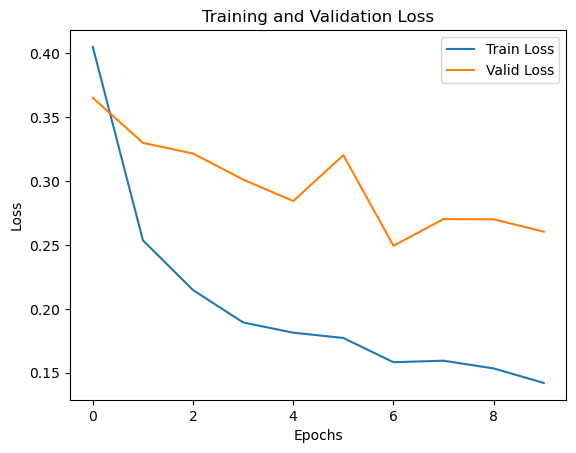

In [52]:
# Plot train_loss and valid_loss
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [17]:
#QUESTA E' LA FUNZIONE PER GENERARE I VETTORI DI ENCODING
def get_encoding_csv(model, anc_img_names, dirFolder):
    """
    Generates encoding vectors for a set of input images using a provided model and returns a DataFrame
    with image names and their corresponding encodings.

    Parameters
    ----------
        model (torch.nn.Module): the neural network model used to generate embeddings.
        anc_img_names (list or numpy.ndarray): filenames (or paths) of the anchor images.
        dirFolder (str): the directory path where the anchor images are located.

    Returns
    -------
        df_enc (pandas.DataFrame): a DataFrame containing the anchor image names and their corresponding encodings.
    """
    # Convert the list of anchor image names to a NumPy array
    anc_img_names_arr = np.array(anc_img_names)

    encodings = []

    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            # Read the image from the specified directory
            A = io.imread(dirFolder + i)
            # Add a batch dimension to the image
            A = np.expand_dims(A, 0)
            # Convert the image to a PyTorch tensor and normalize to the range [0, 1]
            A = torch.from_numpy(A.astype(np.int32)) / 255.0
            #A = torch.from_numpy(A).permute(2, 0, 1) / 255.0 #FOR RGB IMAGES
            
            A = A.to(DEVICE)
            # Pass the preprocessed image through the model to obtain its embedding
            A_enc = model(A.unsqueeze(0))
             # Append the embedding to the list (move to CPU and convert to NumPy array)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())

        # Convert the list of embeddings to a NumPy array
        encodings = np.array(encodings)
        # Create a DataFrame with the embeddings
        encodings = pd.DataFrame(encodings)
        # Concatenate the anchor image names with their corresponding embeddings
        df_enc = pd.concat([anc_img_names, encodings], axis = 1)

        return df_enc

In [ ]:
# Load the best model found during training
model.load_state_dict(torch.load('best_model.pt'))

# Call 'get_encoding_csv' on the dataset to generate the DataFrame containing anchors and their encoding vector
df_enc = get_encoding_csv(model, df['anchor'], DATA_DIR)

# Save the encodings database to avoid redoing this process
# (This process has to be redone only when finding a better model)
df_enc.to_csv(DATA_DIR + 'database.csv', index = False)

df_enc = pd.read_csv(DATA_DIR + 'database.csv')
df_enc.head()

In [19]:
def euclidean_dist(img_enc, anc_enc_arr):
    """
    Computes the Euclidean distance between a given image encoding and an array of anchor encodings.

    Parameters
    ----------
        img_enc (numpy.ndarray): a 1D array representing the encoding of the image.
        anc_enc_arr (numpy.ndarray): a 2D array representing the anchor images and their encodings.

    Returns
    -------
        dist (numpy.ndarray): a 1D array containing the Euclidean distances between the image encoding and each of the anchors' one.
    """
    #dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T))
    dist = np.dot(img_enc-anc_enc_arr, (img_enc- anc_enc_arr).T)
    #dist = np.sqrt(dist)
    
    return dist

In [20]:
test_df = pd.read_csv(DATA_DIR + 'testSet.csv')
print(test_df['real'])
print(test_df.size)
test_df.head()

0       fourier\fourier\coco+coco+coco2017+train2017+r...
1       fourier\fourier\coco+coco+coco2017+train2017+r...
2       fourier\fourier\coco+coco+coco2017+test2017+re...
3       fourier\fourier\coco+coco+coco2017+train2017+r...
4       fourier\fourier\coco+coco+coco2017+train2017+r...
                              ...                        
3106          fourier\fourier\lsun+car+car+real785193.jpg
3107      fourier\fourier\lsun+horse+horse+real055817.jpg
3108          fourier\fourier\lsun+car+car+real062109.jpg
3109          fourier\fourier\lsun+car+car+real124524.jpg
3110          fourier\fourier\lsun+car+car+real000938.jpg
Name: real, Length: 3111, dtype: object
6222


,real,fake
0,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+80+fak...
1,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+747+fa...
2,fourier\fourier\coco+coco+coco2017+test2017+re...,fourier\fourier\big_gan+big+biggan-data+283+fa...
3,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+74+fak...
4,fourier\fourier\coco+coco+coco2017+train2017+r...,fourier\fourier\big_gan+big+biggan-data+414+fa...


In [21]:
def getImageEmbeddings(img, model):
    """
    Generates embeddings for a given image using the provided model.

    Parameters
    ----------
        img (numpy.ndarray): the input image as a NumPy array.
        model (torch.nn.Module): the PyTorch model used to generate the image embeddings.

    Returns
    -------
        img_enc (numpy.ndarray): the embeddings of the input image.
    """
    # Add a new dimension to the image array to match the expected input shape of the model
    img = np.expand_dims(img, 0)
    
    # Convert the NumPy array to a PyTorch tensor and normalize pixel values to the range [0, 1]
    img = torch.from_numpy(img) / 255.0
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for efficiency
    with torch.no_grad():
        # Move the image tensor to the appropriate device (CPU or GPU)
        img = img.to(DEVICE)
        
        # Add a batch dimension, pass the image through the model to get the embeddings
        img_enc = model(img.unsqueeze(0))
        
        # Detach the embeddings from the computation graph and move them back to the CPU
        img_enc = img_enc.detach().cpu().numpy()
        
        # Convert the embeddings to a NumPy array
        img_enc = np.array(img_enc)

    return img_enc

In [22]:
def searchInDatabase(img_enc, database):
    """
    Searches for the closest match to a given image embedding in a database of embeddings.

    Parameters
    ----------
    img_enc (numpy.ndarray): the embedding of the input image.
    database (pandas.DataFrame): a DataFrame containing image embeddings with 'anchor' column for image names and subsequent columns for embedding values.

    Returns
    -------
    (str): the name of the anchor image in the database that is closest to the input image embedding.
    """
    # Extract the embeddings and image names from the database
    anc_enc_arr = database.iloc[:, 1:].to_numpy()  # All columns except the first one (assuming embeddings start from the second column)

    # Initialize an empty list to store distances
    distance = []

    # Iterate over each embedding in the database
    for i in range(anc_enc_arr.shape[0]):
        # Compute the Euclidean distance between the input embedding and the current database embedding
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        # Append the computed distance to the distance list
        distance = np.append(distance, dist)

    # Find the index of the closest embedding by sorting distances
    closest_idx = np.argsort(distance)

    # Return the name of the closest anchor image
    return database['anchor'][closest_idx[0]]

In [23]:
def prediction_fn(test_df, currentTest, y_pred, model, database):
    """
    Tests model predictive capability.

    Parameters
    ----------
        test_df (pandas.DataFrame): DataFrame containing the test images.
        currentTest (str): desired images to test the model on.
        y_pred (list): a list to store the predictions ('real' or 'fake') for each test image.
        model (torch.nn.Module): the PyTorch model used to generate the image embeddings.
        database (pandas.DataFrame): the DataFrame containing image embeddings with 'Anchor' column for image names and subsequent columns for embedding values.
    """

    # Iterate over each row in the test DataFrame with progress bar
    for index, row in tqdm(test_df.iterrows(), total=len(test_df)):
        # Construct the full image path
        img_name = DATA_DIR + row[currentTest]
        
        # Read the image from the path
        img = io.imread(img_name)

        # Get the image embeddings using the model
        img_enc = getImageEmbeddings(img, model)

        # Search for the closest match in the database
        closestLabel = searchInDatabase(img_enc, database)

        # Determine if the closest match is 'real' or 'fake' and append the result to pred_vector
        if "real" in closestLabel:
            y_pred.append("real")
        else:
            y_pred.append("fake")


In [12]:
def calculate_metrics(test_df,y_pred, y_true):
    
    #Ground truth vectors creation
    y_true = np.array(['real'] * len(test_df))
    temp = np.array(['fake'] * len(test_df))
    y_true = np.concatenate([y_true, temp])

    # Confusion Matrix calculation
    cm = confusion_matrix(y_true, y_pred, labels=["real","fake"])

    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # True Negative, False Positive, False Negative, True Positive extraction
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred, labels=["real", "fake"]).ravel()
    print(f"Numero di veri negativi {TN}")
    print(f"Numero di veri negativi {FP}")
    
    # Metrics calculation
    accuracy = round((TP + TN) /(TP + TN + FP + FN), 4) * 100
    precision = round((TP) / (TP + FP), 4) * 100
    sensitivy_recall = round((TP) / (TP + FN), 4) * 100
    specificity = round((TN) / (TN + FP) * 100, 4)
    F1_score = round((2* precision * sensitivy_recall) / (precision + sensitivy_recall), 2)

    print({"Accuracy":accuracy,"Precision":precision,"Sensitivity_recall":sensitivy_recall, "Specificity": specificity, "F1_score":F1_score})

In [ ]:
# Testing prep
y_true = []
y_pred = []
tempDf = test_df
database = df_enc


# Testing on FAKE images
prediction_fn(tempDf, 'real', y_pred, model, database)

# Testing on REAL images
prediction_fn(tempDf, 'fake', y_pred, model, database)

# Metrics calculation
calculate_metrics(tempDf, y_pred, y_true)


In [62]:
def get_testSet_dirs(test_df):

	real_dirs_list = []
	fake_dirs_list = []

	for index, row in tqdm(test_df.iterrows(), total=test_df.shape[0], desc="Extracting generator directories"):
		
		r_dir = row["real"].split('fourier\\fourier\\')[1].split('+')[0]
		f_dir = row["fake"].split('fourier\\fourier\\')[1].split('+')[0]

		real_dirs_list.append(r_dir)
		fake_dirs_list.append(f_dir)

	real_dirs = sorted(set(real_dirs_list))
	fake_dirs = sorted(set(fake_dirs_list))

	return real_dirs, fake_dirs

In [63]:
def get_testSet_subsets(test_df):

    real_dirs, fake_dirs = get_testSet_dirs(test_df)
    print(real_dirs)
    print(fake_dirs)

    real_subsets = {dir: test_df[test_df['real'].str.startswith("fourier\\fourier\\" + dir + '+')]['real'].tolist() for dir in real_dirs}
    fake_subsets = {dir: test_df[test_df['fake'].str.startswith("fourier\\fourier\\" + dir + '+')]['fake'].tolist() for dir in fake_dirs}

    real_subsets_df = {dir: pd.DataFrame(subset, columns=['real']) for dir, subset in real_subsets.items()}
    fake_subsets_df = {dir: pd.DataFrame(subset, columns=['fake']) for dir, subset in fake_subsets.items()}

    return real_subsets_df, fake_subsets_df

Extracting generator directories:   0%|          | 0/3111 [00:00<?, ?it/s]

['coco', 'imagenet', 'lsun']
['big_gan', 'latent_diffusion', 'taming_transformer']


  0%|          | 0/1037 [00:00<?, ?it/s]




Metrics summary for big_gan:


  0%|          | 0/1037 [00:00<?, ?it/s]

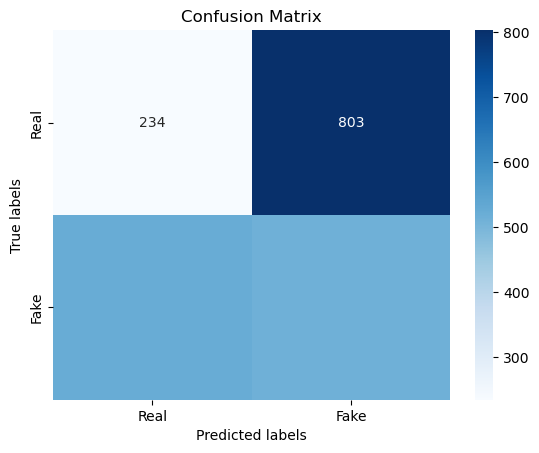

Classification Report:
              precision    recall  f1-score   support

        fake       0.39      0.50      0.44      1037
        real       0.31      0.23      0.26      1037

    accuracy                           0.36      2074
   macro avg       0.35      0.36      0.35      2074
weighted avg       0.35      0.36      0.35      2074

{'Accuracy': 36.07, 'Precision': 39.03, 'Sensitivity_recall': 49.57, 'Specificity': 22.5651, 'F1_score': 43.67}



Metrics summary for latent_diffusion:


  0%|          | 0/1037 [00:00<?, ?it/s]

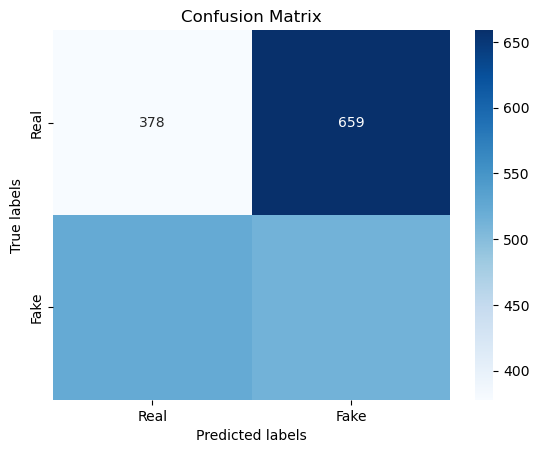

Classification Report:
              precision    recall  f1-score   support

        fake       0.44      0.50      0.47      1037
        real       0.42      0.36      0.39      1037

    accuracy                           0.43      2074
   macro avg       0.43      0.43      0.43      2074
weighted avg       0.43      0.43      0.43      2074

{'Accuracy': 43.01, 'Precision': 43.82, 'Sensitivity_recall': 49.57, 'Specificity': 36.4513, 'F1_score': 46.52}



Metrics summary for taming_transformer:


  0%|          | 0/1037 [00:00<?, ?it/s]

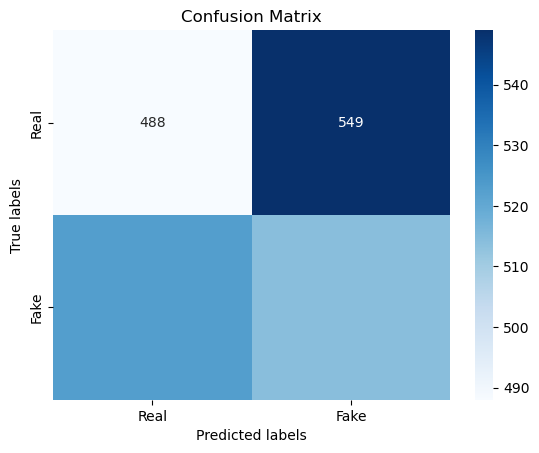

Classification Report:
              precision    recall  f1-score   support

        fake       0.48      0.50      0.49      1037
        real       0.48      0.47      0.48      1037

    accuracy                           0.48      2074
   macro avg       0.48      0.48      0.48      2074
weighted avg       0.48      0.48      0.48      2074

{'Accuracy': 48.309999999999995, 'Precision': 48.35, 'Sensitivity_recall': 49.57, 'Specificity': 47.0588, 'F1_score': 48.95}


In [64]:
# HERE ARE CALCULATED INDIVIDUAL METRICS FOR EACH FAKE GENERATOR
real_subsets, fake_subsets = get_testSet_subsets(test_df)

# Lenght matching 
first_real_key = next(iter(real_subsets))
first_fake_key = next(iter(fake_subsets))

real_df = real_subsets[first_real_key]
first_fake_df = fake_subsets[first_fake_key] 

real_df = real_df.head(len(first_fake_df))

# Testing prep
y_pred_real = [] #Avoid redoing predictions on the same real images subset
y_pred = []
database = df_enc

# Testing on REAL images
prediction_fn(real_df, 'real', y_pred_real, model, database)

for dir, df in fake_subsets.items():
    print(f"\n\n\nMetrics summary for {dir}:")
    
    y_true = []
    y_pred = y_pred_real.copy()

    # Testing on FAKE images
    prediction_fn(df, 'fake', y_pred, model, database)
    # Metrics calculation
    # (the df in input makes no differences)
    calculate_metrics(df, y_pred, y_true)